In [4]:
import tensorflow as tf
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import keras
import csv
import numpy as np
from pathlib import Path
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.src.layers import Flatten, Dense, Dropout, Rescaling
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.applications.vgg16 import VGG16
from keras.src.optimizers import Adam, SGD, RMSprop
from keras.src.models import Sequential, Model
from keras.src.saving.saving_lib import load_model, save_model
from keras.src.utils import load_img, img_to_array, get_file, image_dataset_from_directory,array_to_img
from keras.src.applications.xception import Xception, preprocess_input, decode_predictions
from IPython.display import Image, display

In [3]:
# Parameters
batch_size = 32
IMG_SIZE = (224, 224)
DATA_DIR = "../project_data/spectrograms"

# Devide the dataset into training, validation, and test sets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,  # 30% of data for validation
    subset="training",     # training subset
    seed=42,               # random seed for reproducibility
    image_size=IMG_SIZE,   # resize images to this size
    batch_size=batch_size, # batch size
    label_mode="int"       # labels as integers
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="int"
)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 999 files belonging to 10 classes.
Using 700 files for training.
Found 999 files belonging to 10 classes.
Using 299 files for validation.


In [19]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels:", labels.numpy())

Images shape: (32, 224, 224, 3)
Labels: [9 4 8 0 0 8 5 3 3 0 5 7 0 0 1 5 0 6 2 5 7 1 0 8 0 5 9 2 5 5 6 0]


In [8]:
optimizers = ['adam', 'sgd', 'rmsprop']
learning_rates = [1e-3, 1e-4, 1e-5]
dropout_rates = [0.3, 0.4]
hidden_units = [128, 256]
blocks_of_layers_to_unlock = [5, 45]

def safe_float_str(value):
    return str(value).replace('.', 'p').replace('-', 'm')

In [30]:
def build_vgg_model(num_classes, optimizer, learning_rate, dropout_rate, hidden_units, block):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # if weights are frozen

    # Unfreeze some layers for fine-tuning
    if block == 4:
        for layer in base_model.layers:
            if layer.name.startswith("block4"):
                layer.trainable = True
    if block == 5:
        for layer in base_model.layers:
            if layer.name.startswith("block5"):
                layer.trainable = True
    elif block == 45:
        for layer in base_model.layers:
            if layer.name.startswith("block4") or layer.name.startswith("block5"):
                layer.trainable = True

    model = Sequential([
        Rescaling(1./255),                         # normalization
        base_model,                                # VGG16 base model
        Flatten(),                                 # flattening the output
        Dense(hidden_units, activation='relu'),    # hidden layer
        Dropout(dropout_rate),                     # dropout layer
        Dense(num_classes, activation='softmax')   # output layer
    ])

    # wybór optymalizatora
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer. Choose from 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    return model

In [31]:
def train_and_evaluate_model(opt, lr, drop, units,
                              train_ds, val_ds, test_ds, block=0):

    run_id = f"{opt}_lr{safe_float_str(lr)}_drop{safe_float_str(drop)}_units{units}_block{block}"
    model_path = f"models/model_{run_id}.keras"
    hist_path = f"history/train_history_{run_id}.csv"
    pred_path = f"predictions/pred_{run_id}.csv"

    print(f"\n🔧 Training: opt={opt}, lr={lr}, dropout={drop}, units={units}, block={block}")

    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    ]

    # Build the model
    model = build_vgg_model(
        num_classes=10,
        optimizer=opt,
        learning_rate=lr,
        dropout_rate=drop,
        hidden_units=units,
        block=block
    )

    # Check softmax output for sanity
    for images, labels in train_ds.take(1):
        preds = model(images, training=False)
        print("Softmax sum (≈1):", tf.reduce_sum(preds[0]).numpy())
        print("Predicted class:", tf.argmax(preds[0]).numpy())

    # Train the model
    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        callbacks=callbacks,
        verbose=1
    )

    end_time = time.time()
    train_time = end_time - start_time
    print(f"Training time: {train_time:.2f} sekundy")

    # Save training history
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(hist_path, index=False)

    # Load best model and evaluate
    best_model = load_model(model_path)
    test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
    print(f"Test acc: {test_acc:.4f} | Test loss: {test_loss:.4f}")

    # Append summary
    summary_row = {
        "optimizer": opt,
        "learning_rate": lr,
        "dropout": drop,
        "units": units,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "train_time_sec": round(train_time, 2)
    }
    pd.DataFrame([summary_row]).to_csv(summary_file, mode='a', header=not os.path.exists(summary_file), index=False)

    # Save predictions
    y_true = []
    y_pred = []

    for batch in test_ds:
        x_batch, y_batch = batch
        preds = best_model.predict(x_batch, verbose=0)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    pred_df = pd.DataFrame({
        "true_label": y_true,
        "predicted_label": y_pred
    })
    pred_df.to_csv(pred_path, index=False)

In [32]:
os.makedirs("models", exist_ok=True)
os.makedirs("history", exist_ok=True)

# Summary file initialization
summary_file = "models/summary.csv"
if not os.path.exists(summary_file):
    pd.DataFrame(columns=["optimizer", "learning_rate", "dropout", "units", "test_acc", "test_loss", "train_time_sec"]).to_csv(summary_file, index=False)

for opt in optimizers:
    for lr in learning_rates:
        for drop in dropout_rates:
            for units in hidden_units:
                train_and_evaluate_model(
                    opt, lr, drop, units,
                    train_ds=train_ds,
                    val_ds=val_ds,
                    test_ds=test_ds
                )


for block in blocks_of_layers_to_unlock:
    train_and_evaluate_model(
        'adam', 1e-3, 0.3, 128,
        train_ds=train_ds,
        val_ds=val_ds,
        test_ds=test_ds,
        block =block
    )


🔧 Training: opt=adam, lr=0.001, dropout=0.3, units=128, block=0
Softmax sum (≈1): 0.9999999
Predicted class: 4
Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1634 - loss: 2.6925 - val_accuracy: 0.3645 - val_loss: 1.6454
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4136 - loss: 1.6402 - val_accuracy: 0.4206 - val_loss: 1.5366
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4693 - loss: 1.5081 - val_accuracy: 0.5140 - val_loss: 1.3782
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5258 - loss: 1.3334 - val_accuracy: 0.5794 - val_loss: 1.2928
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5510 - loss: 1.2794 - val_accuracy: 0.6075 - val_loss: 1.2490
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6002 - loss: 1.1555 - val_accuracy: 0.6636 - val_loss: 1.1587
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6609 - loss: 1.0508 - val_accuracy: 0.6449 - val_loss: 1.0830
Epoch 

In [41]:
def plot_history(history,run_id):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    # Format the run_id for the plot title
    param_str = run_id.replace('_', ', ').replace('lr', 'lr=').replace('drop', 'drop=').replace('units', 'units=').replace('block', 'block=')

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Accuracy\n{param_str}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss\n{param_str}')

    plt.tight_layout()
    plt.savefig(f"training_plot_{run_id}.png")
    plt.show()

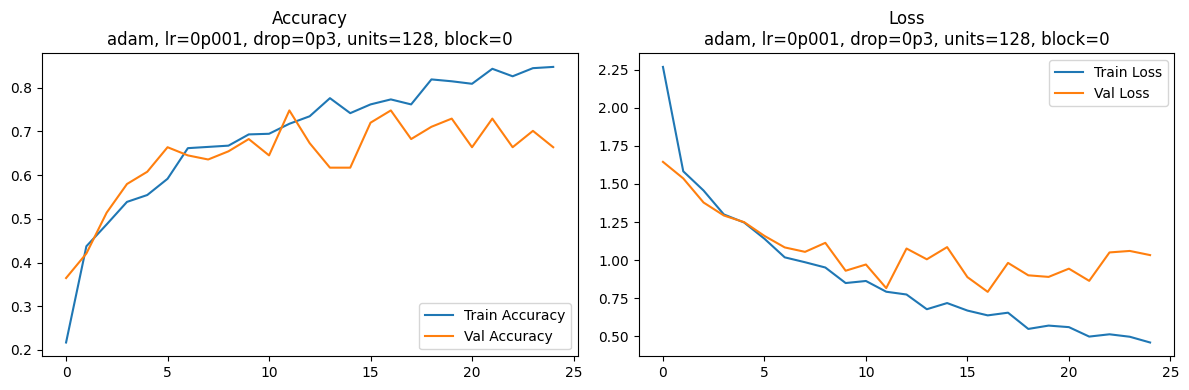

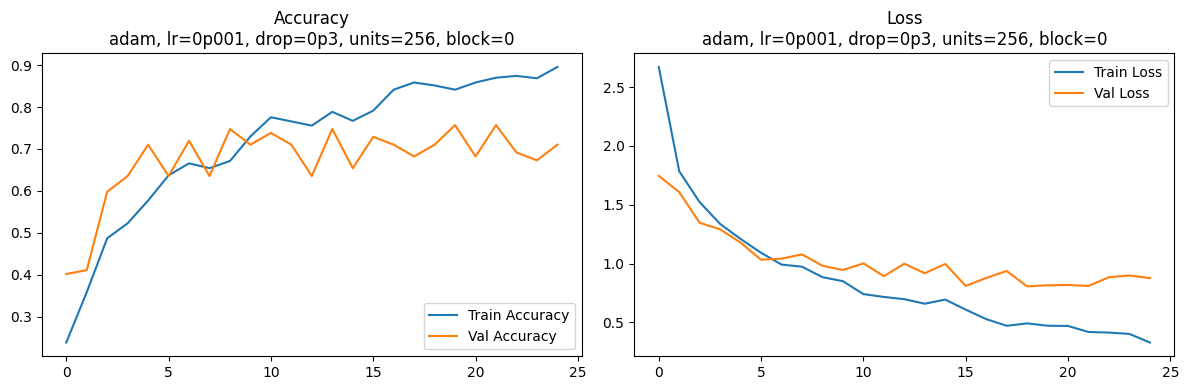

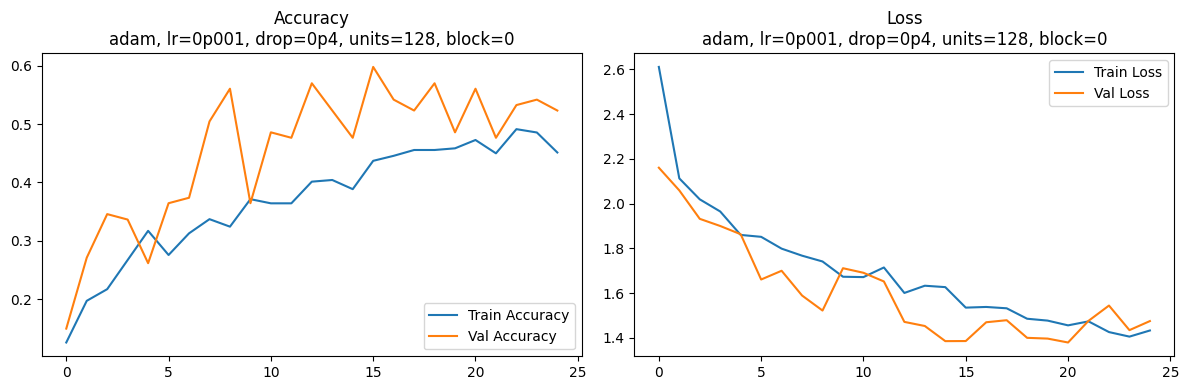

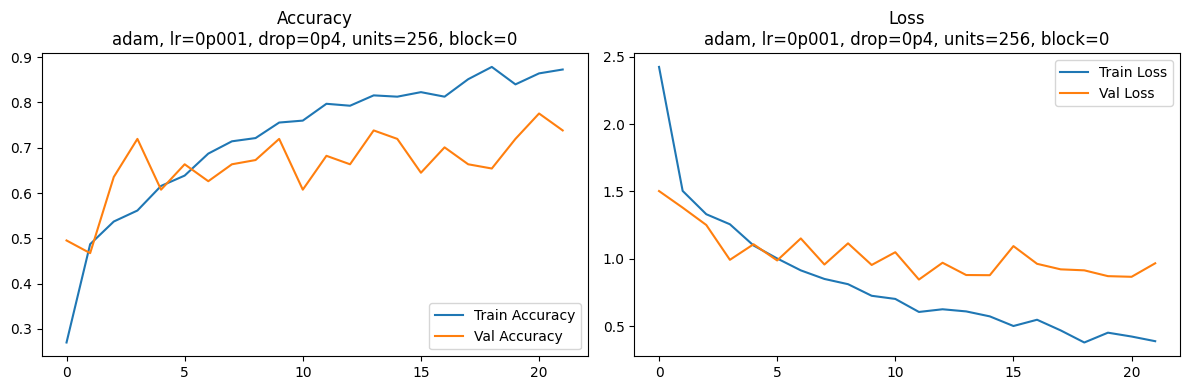

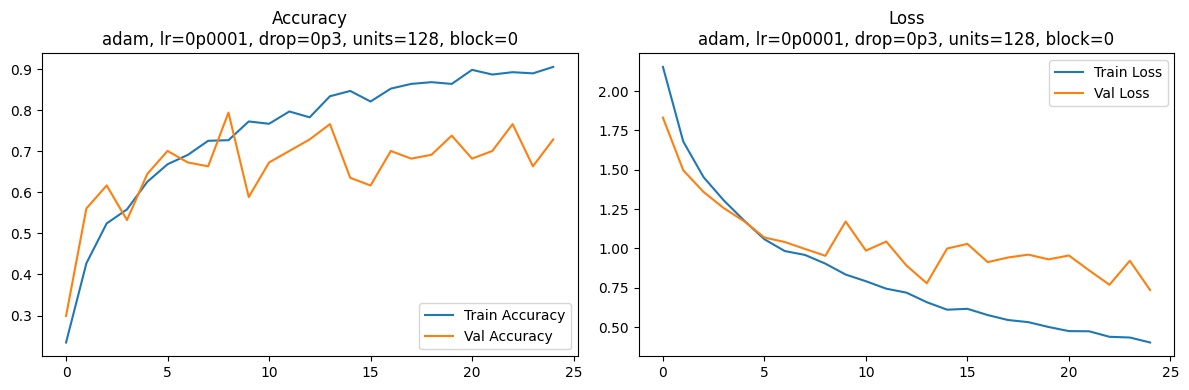

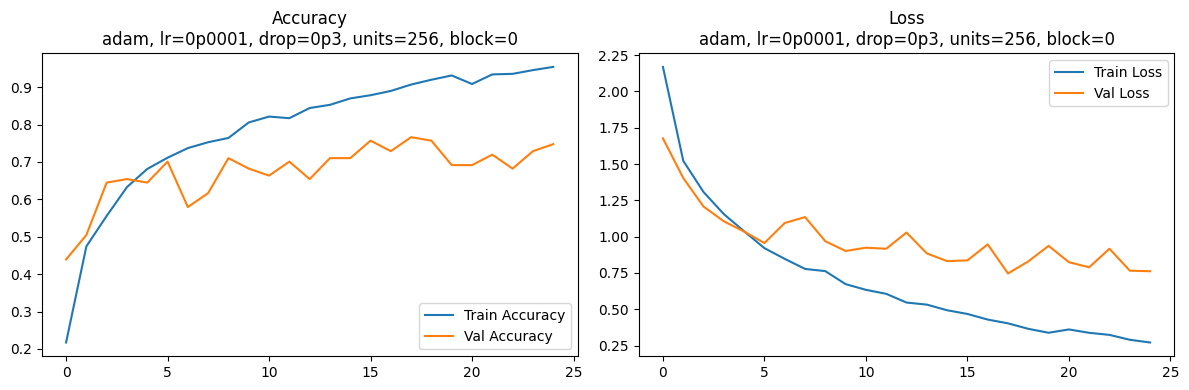

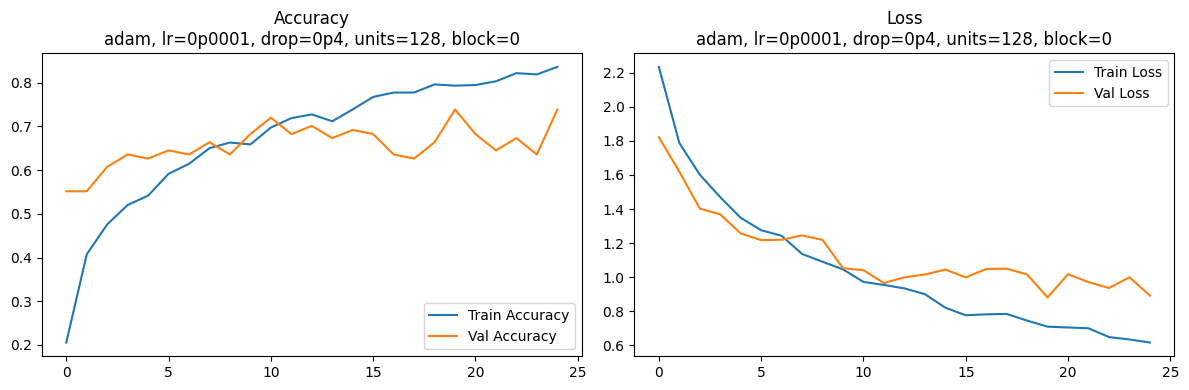

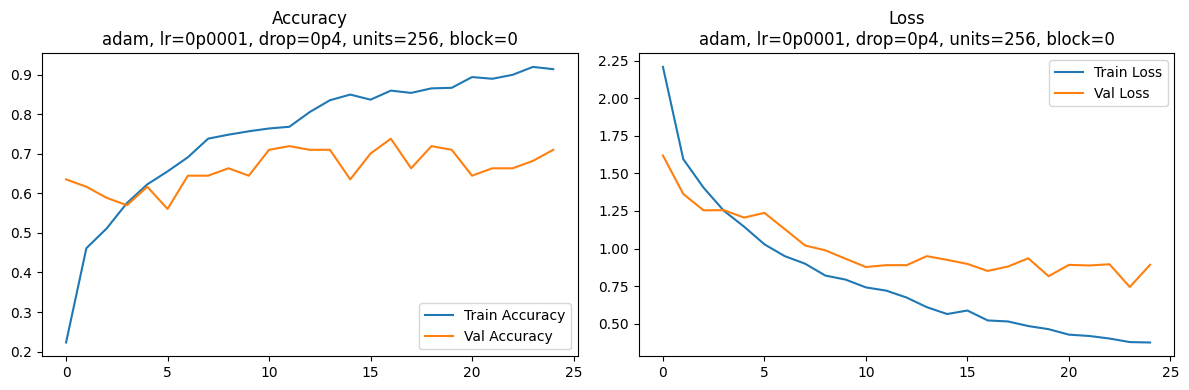

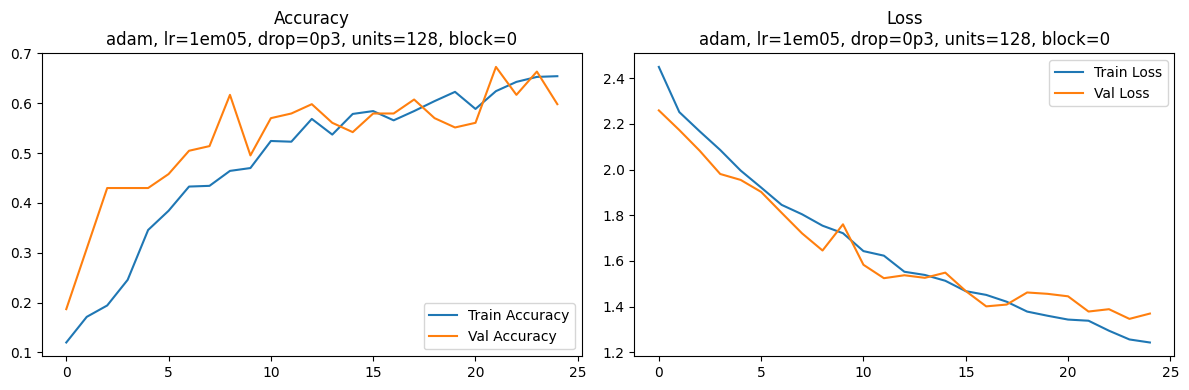

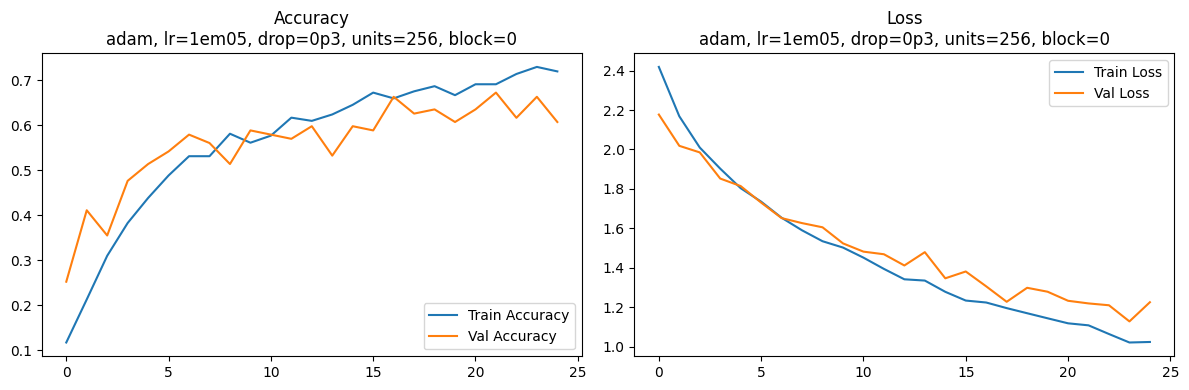

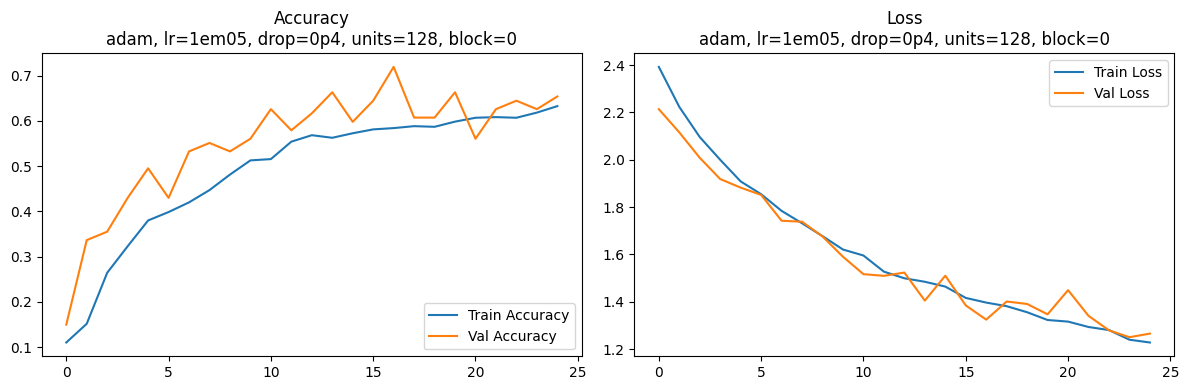

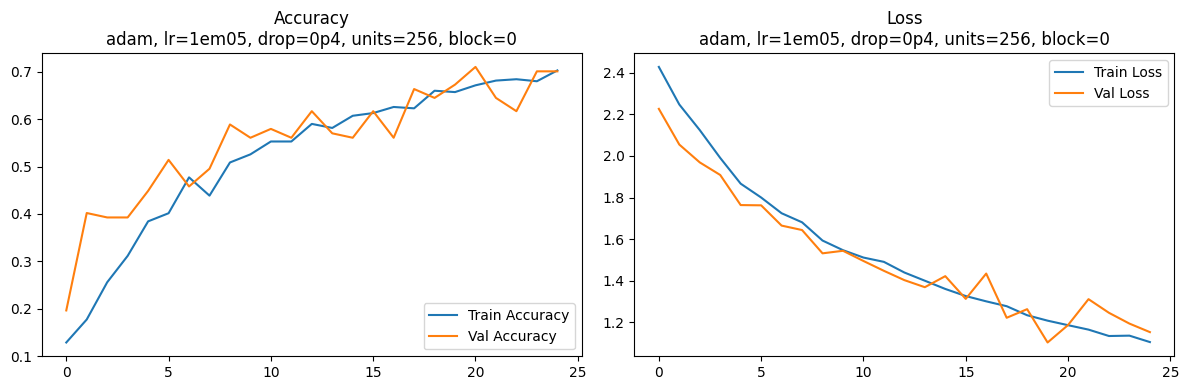

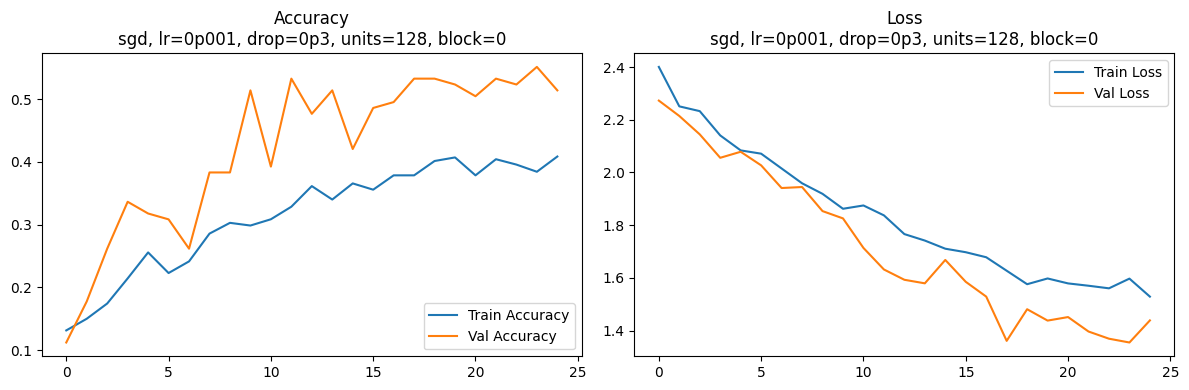

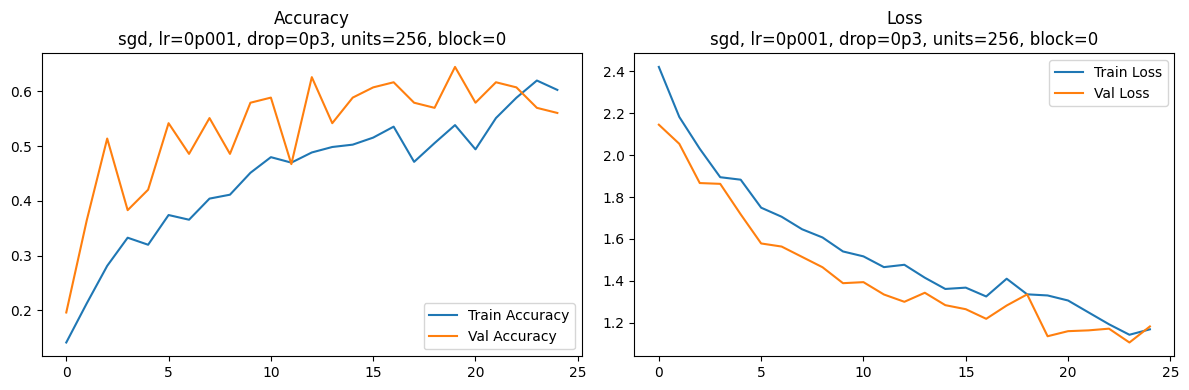

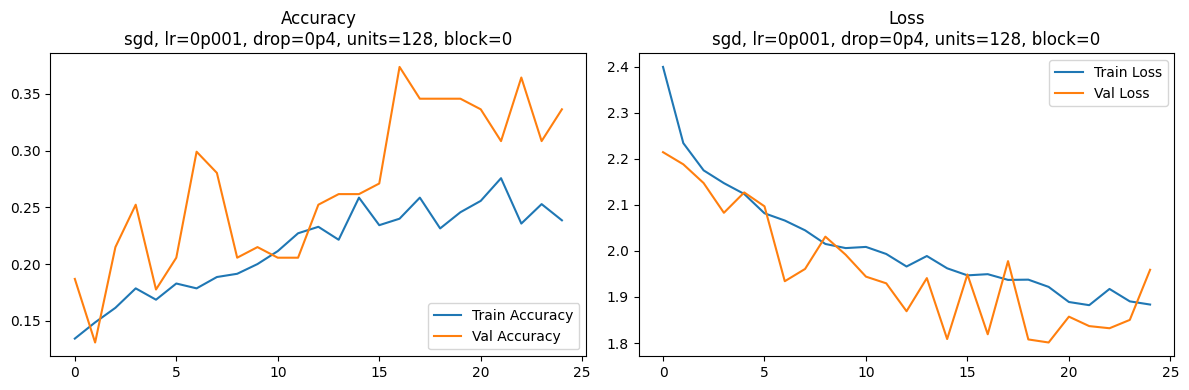

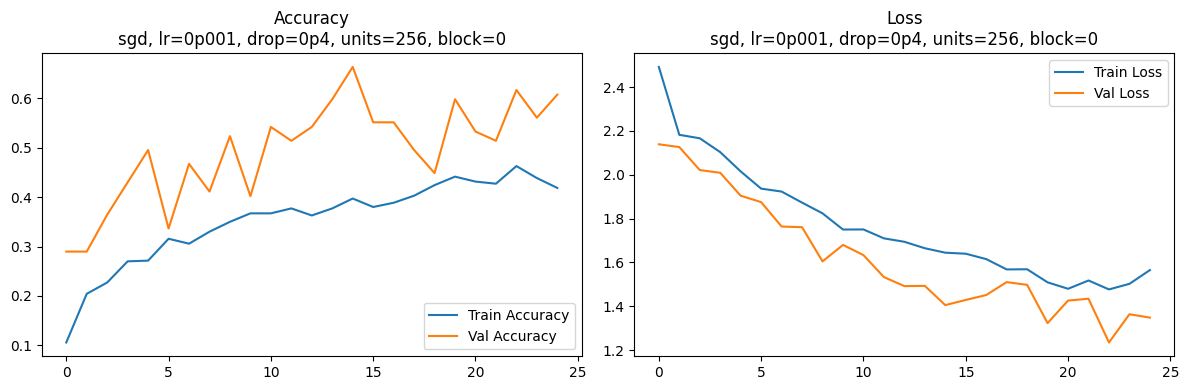

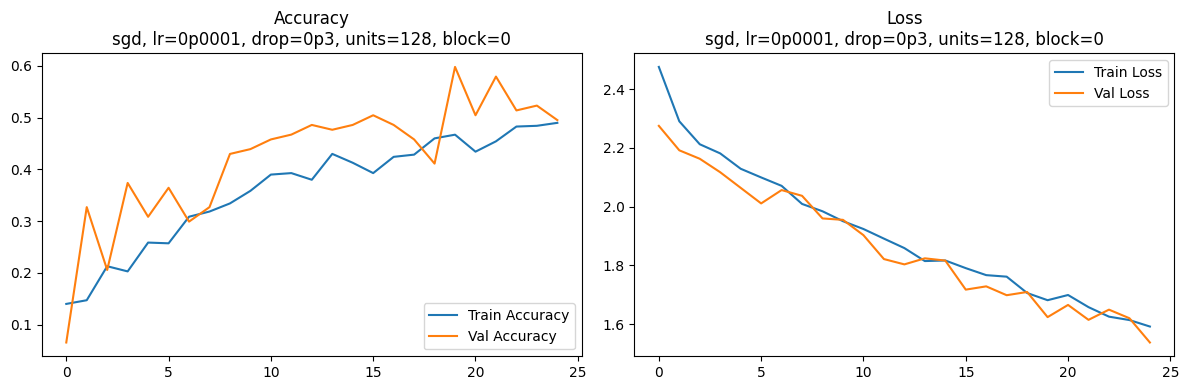

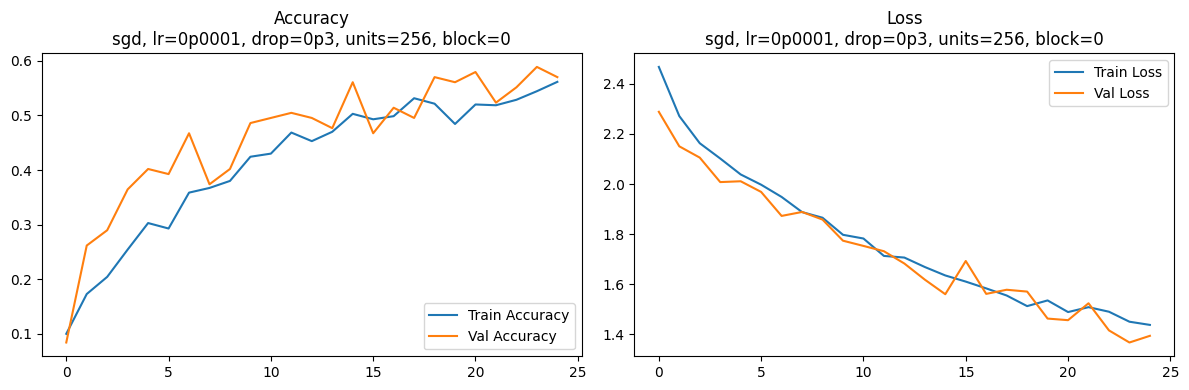

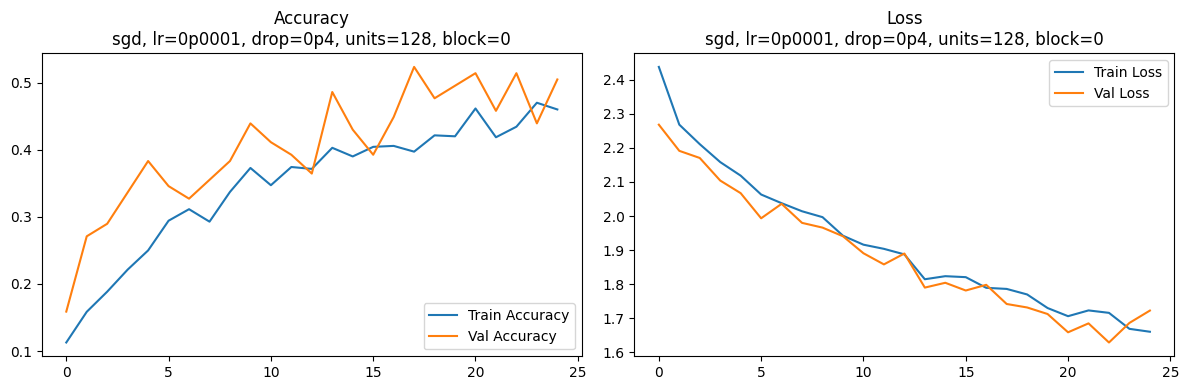

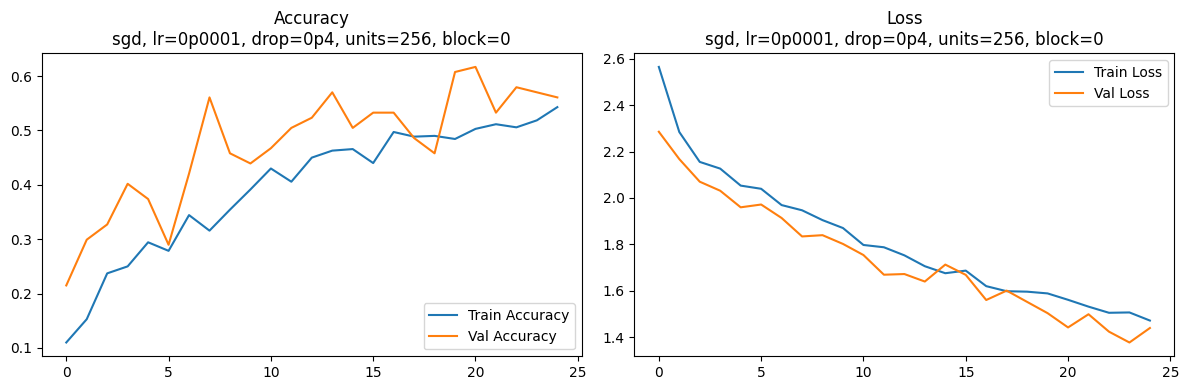

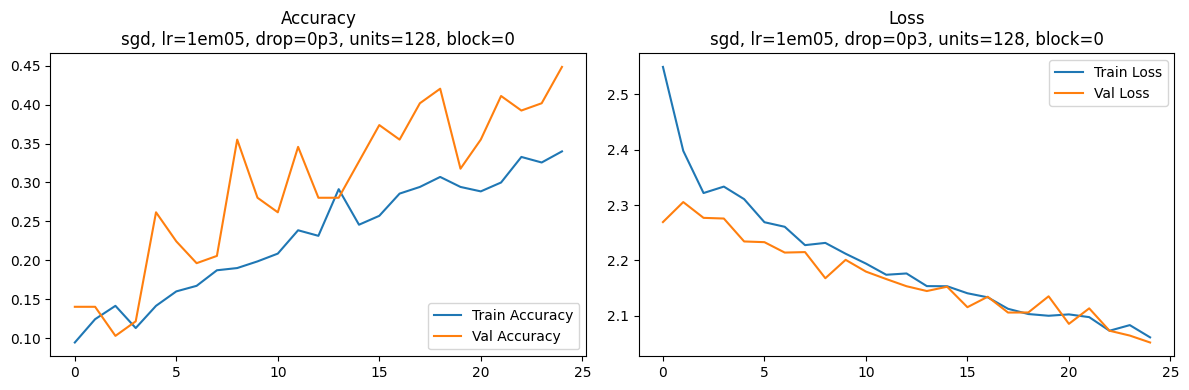

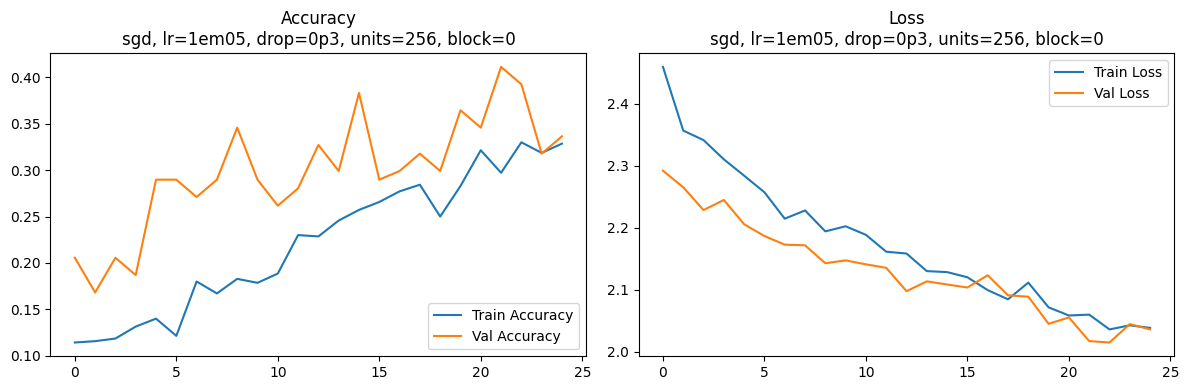

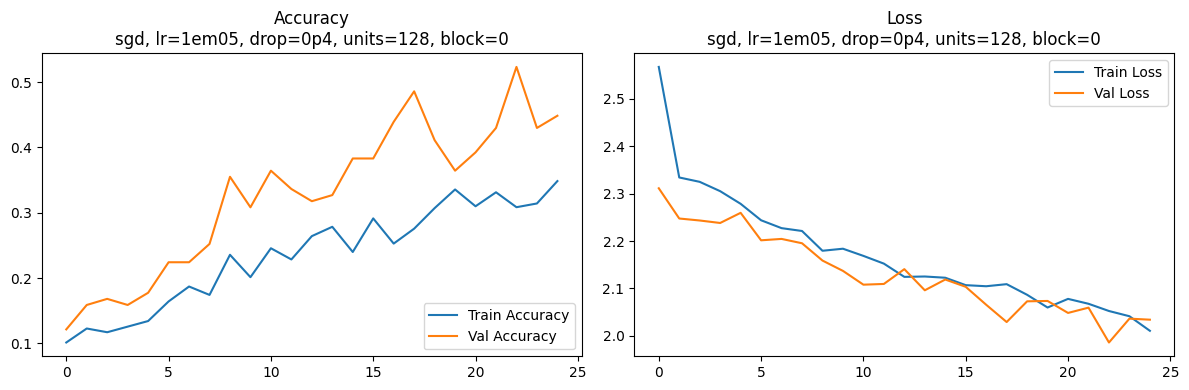

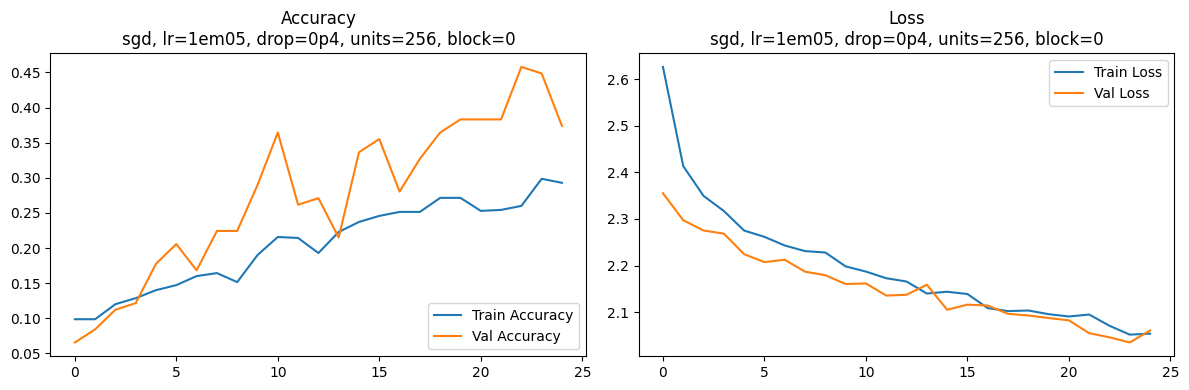

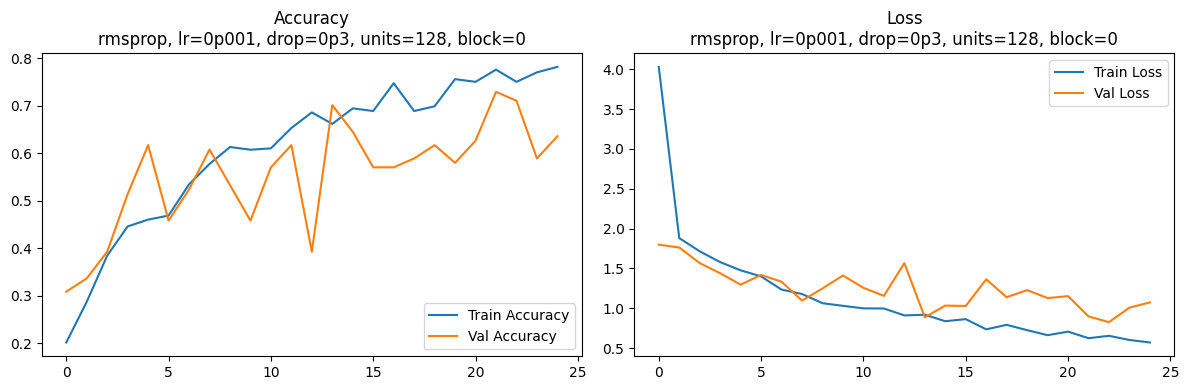

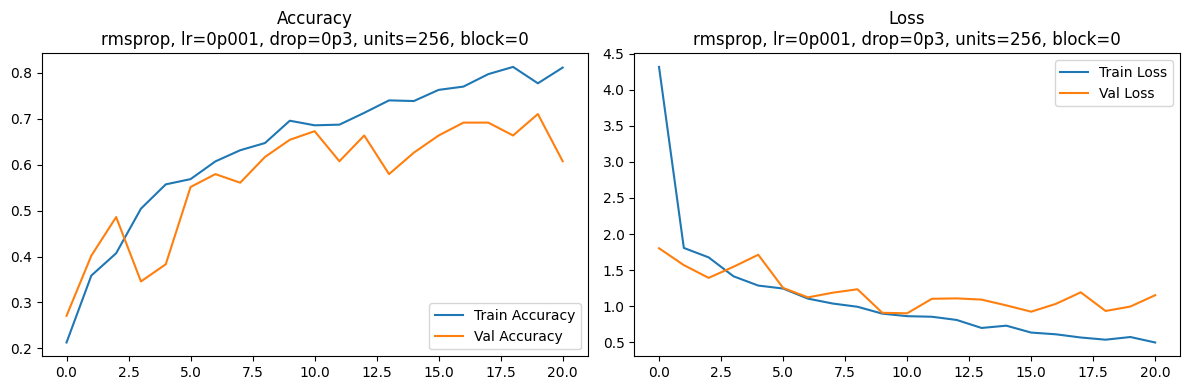

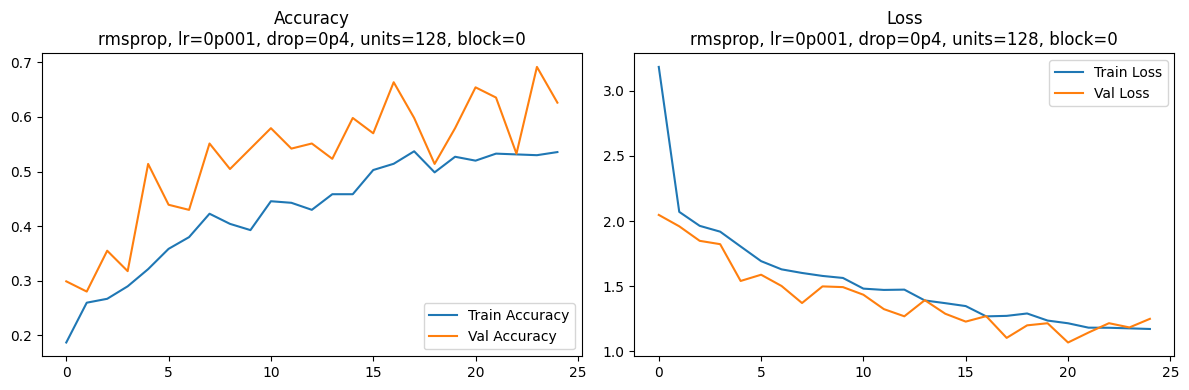

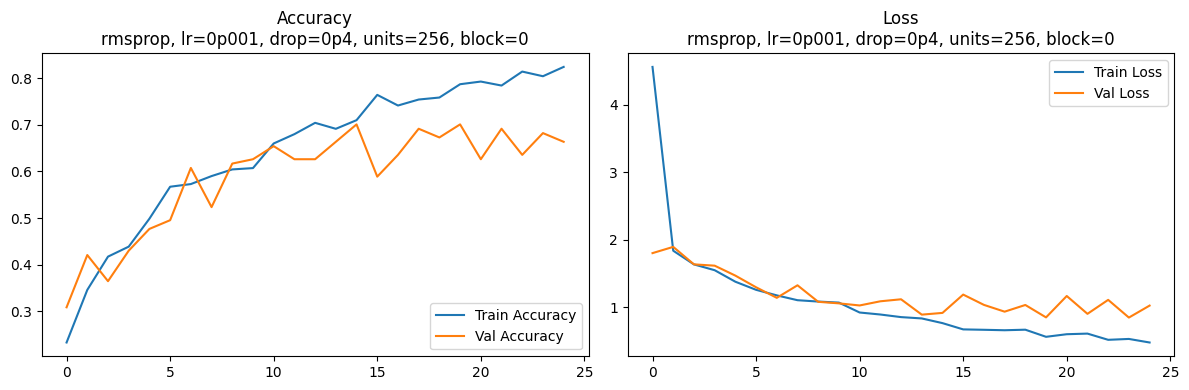

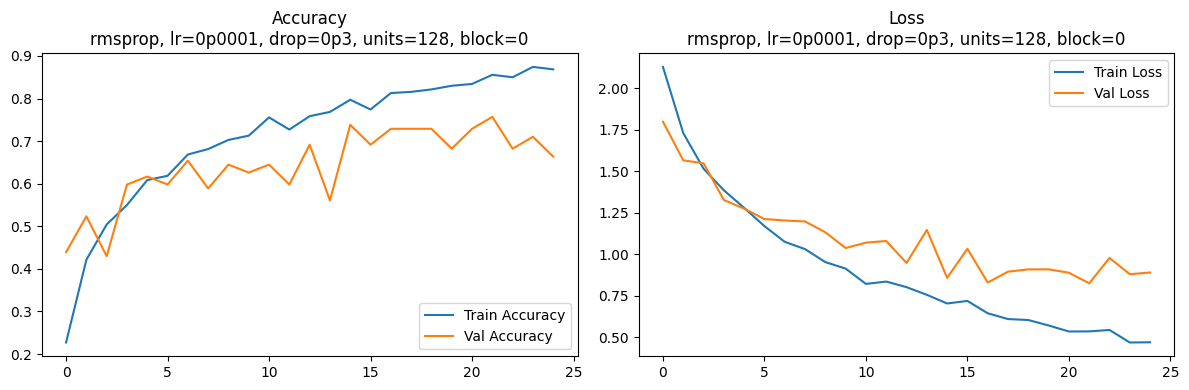

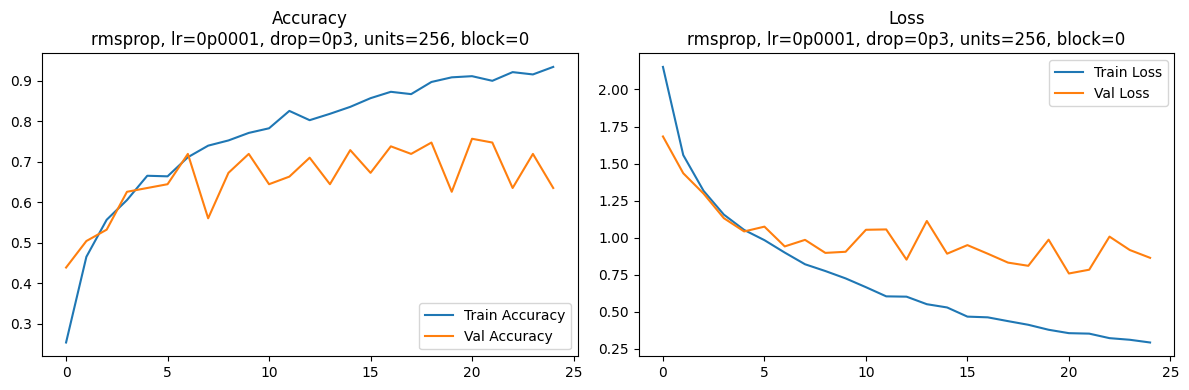

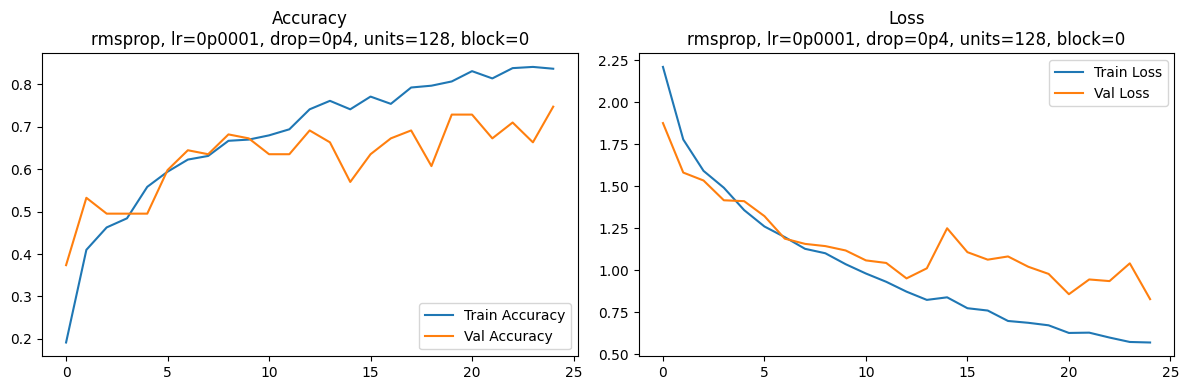

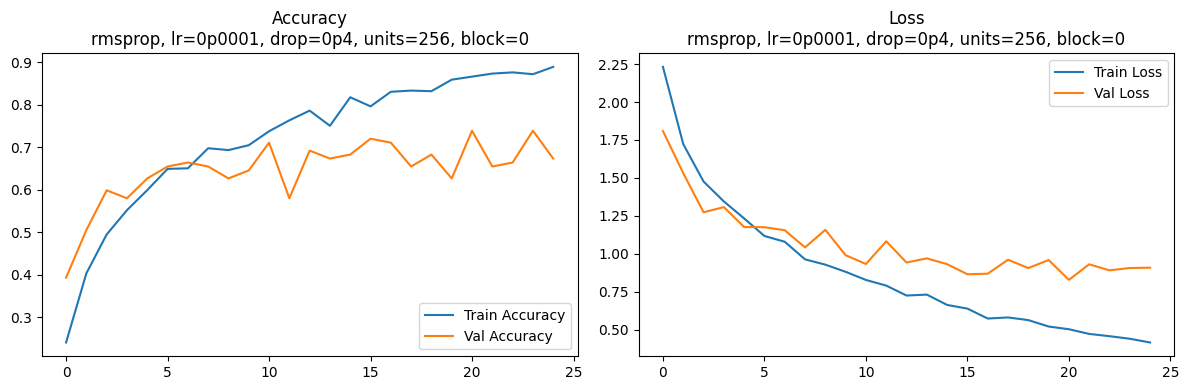

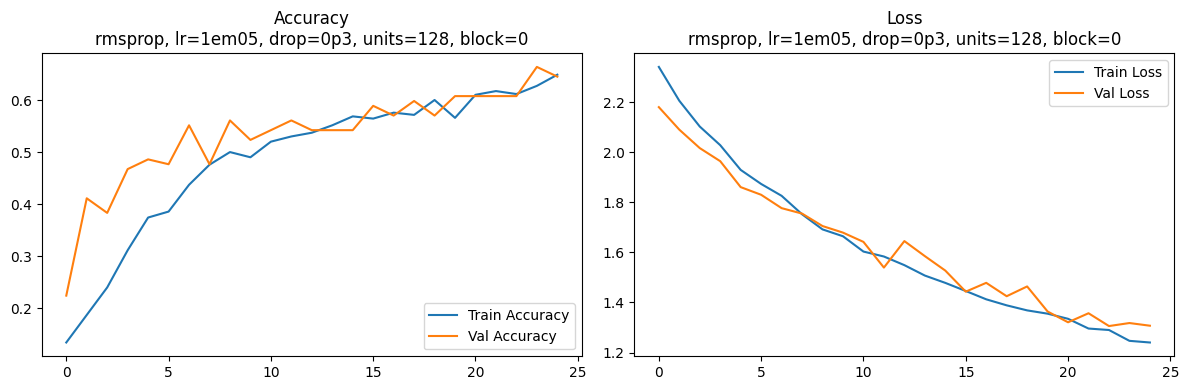

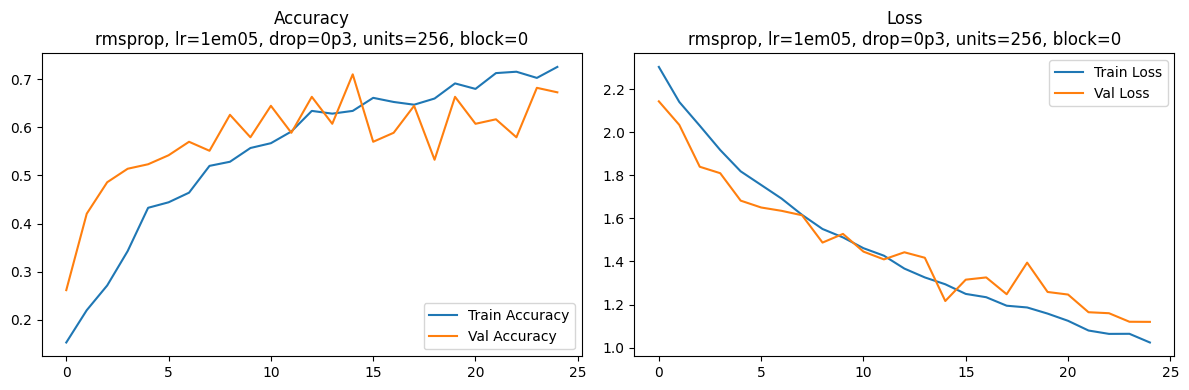

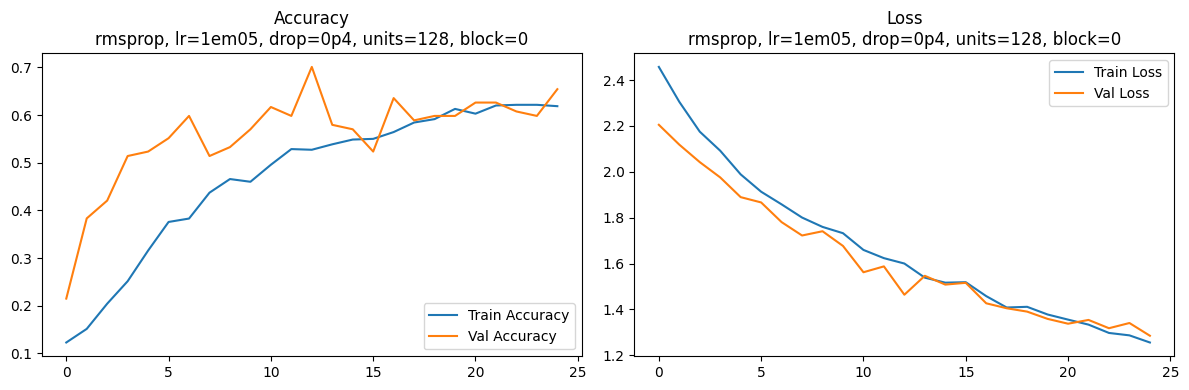

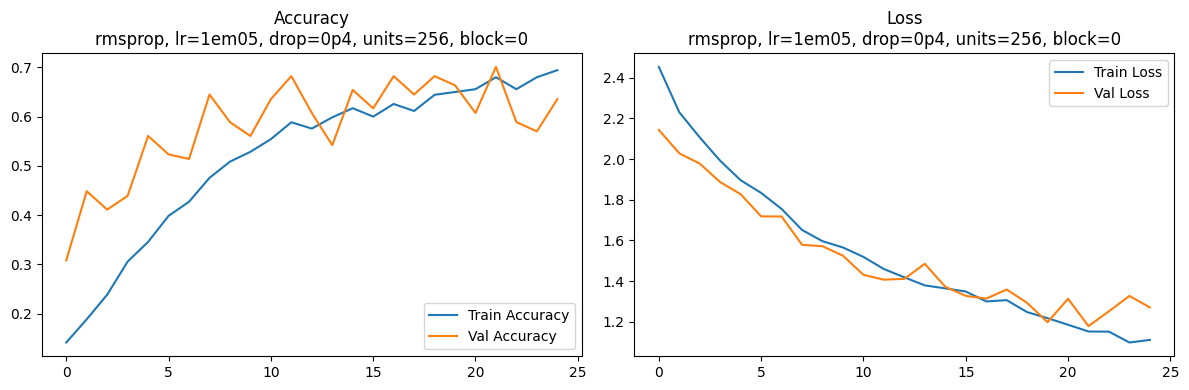

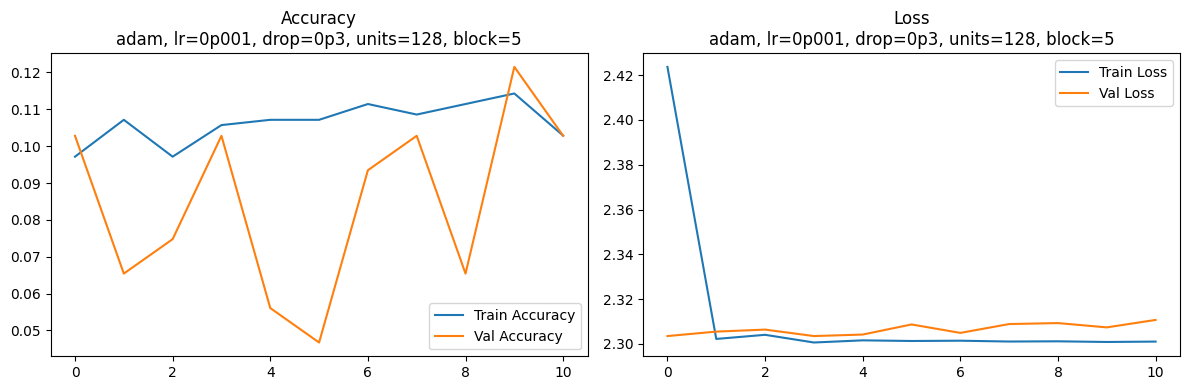

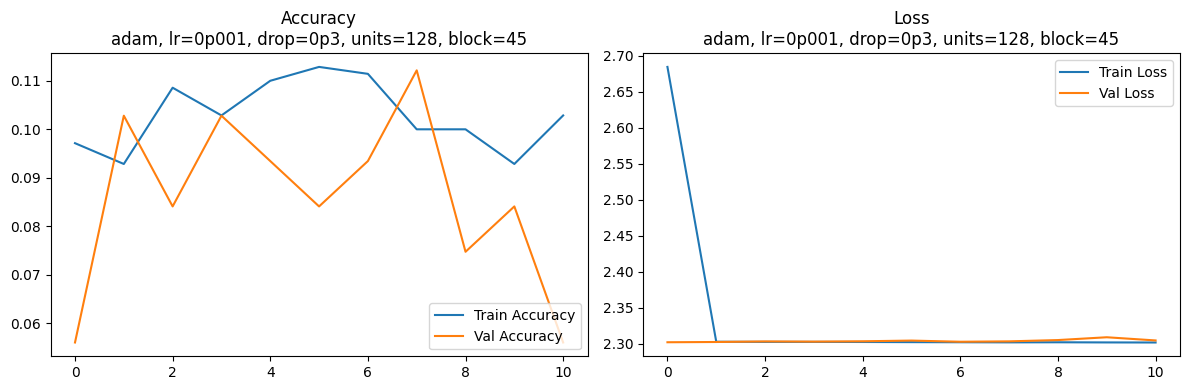

In [43]:
optimizers = ['adam', 'sgd', 'rmsprop']
learning_rates = [1e-3, 1e-4, 1e-5]
dropout_rates = [0.3, 0.4]
hidden_units = [128, 256]
blocks_of_layers_to_unlock = [5, 45]
for opt in optimizers:
    for lr in learning_rates:
        for drop in dropout_rates:
            for units in hidden_units:
                run_id = f"{opt}_lr{safe_float_str(lr)}_drop{safe_float_str(drop)}_units{units}_block0"
                history_dir= f"history/train_history_{run_id}.csv"
                history = pd.read_csv(history_dir)
                plot_history(history,run_id)


for block in blocks_of_layers_to_unlock:
    run_id = f"adam_lr{safe_float_str(1e-3)}_drop{safe_float_str(0.3)}_units128_block{block}"
    history_dir= f"history/train_history_{run_id}.csv"
    history = pd.read_csv(history_dir)
    plot_history(history,run_id)



In [44]:
def plot_confusion_matrix(predictions, run_id):
    y_true = predictions["true_label"]
    y_pred = predictions["predicted_label"]
    param_str = run_id.replace('_', ', ').replace('lr', 'lr=').replace('drop', 'drop=').replace('units', 'units=').replace('block', 'block=')

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix\n{param_str}')
    plt.savefig(f"confusion_matrix_{run_id}.png")
    plt.show()

def ACC_and_PREC(predictions,run_id):
    y_true = predictions["true_label"]
    y_pred = predictions["predicted_label"]
    param_str = run_id.replace('_', ', ').replace('lr', 'lr=').replace('drop', 'drop=').replace('units', 'units=').replace('block', 'block=')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    output_path = "score/results.csv"
    results = {
        "run_id": run_id,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    df = pd.DataFrame([results])
    if os.path.exists(output_path):
        df.to_csv(output_path, mode='a', header=False, index=False)
    else:
        df.to_csv(output_path, mode='w', header=True, index=False)


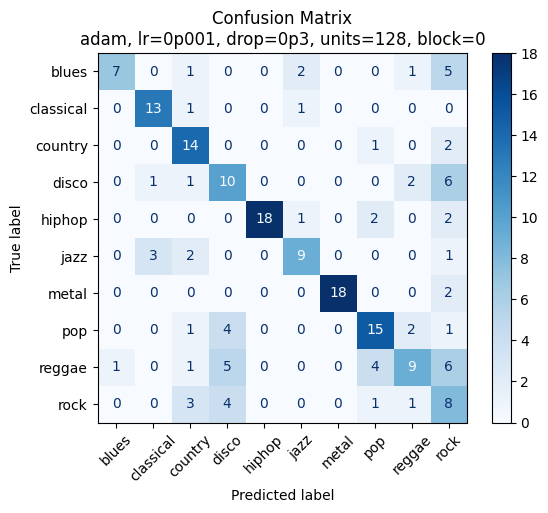

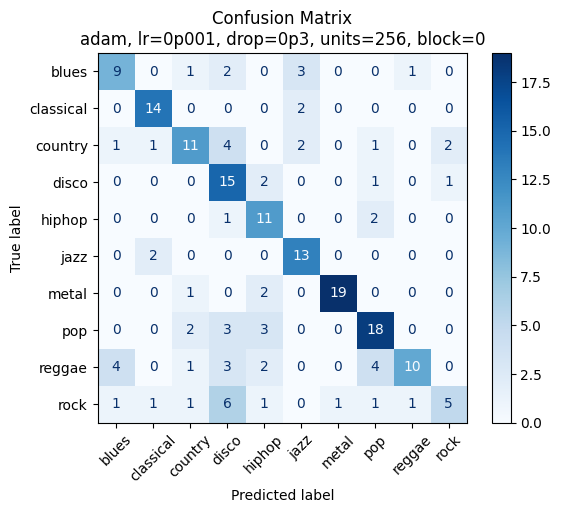

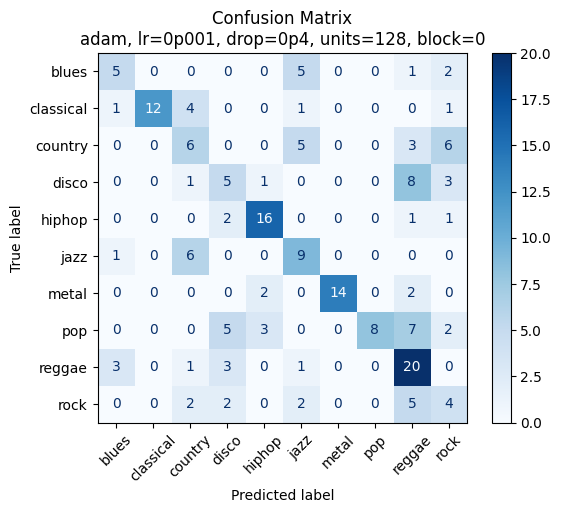

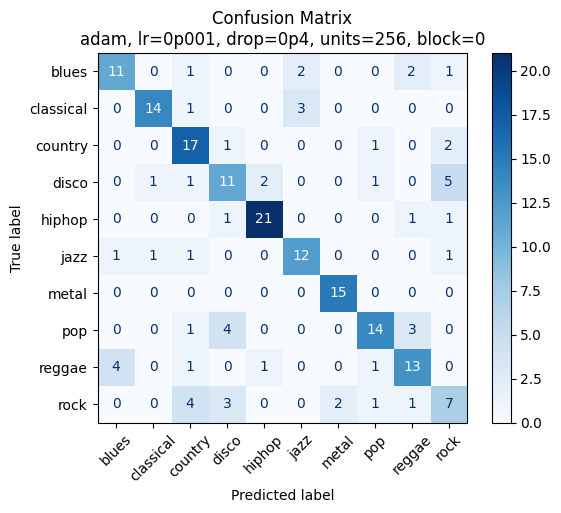

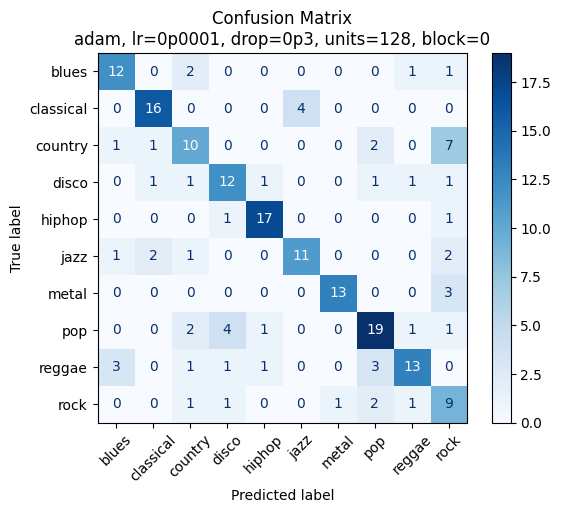

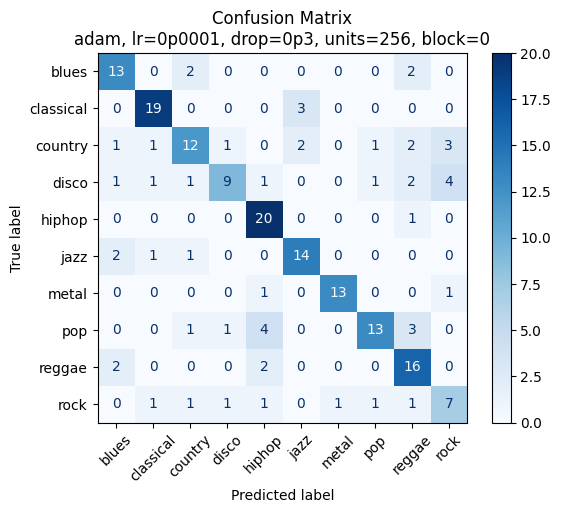

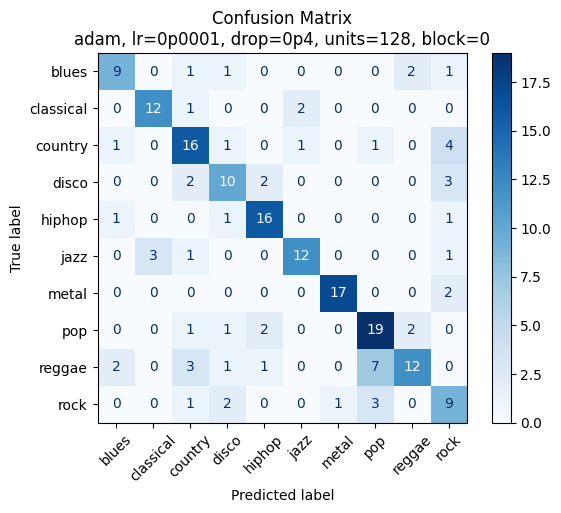

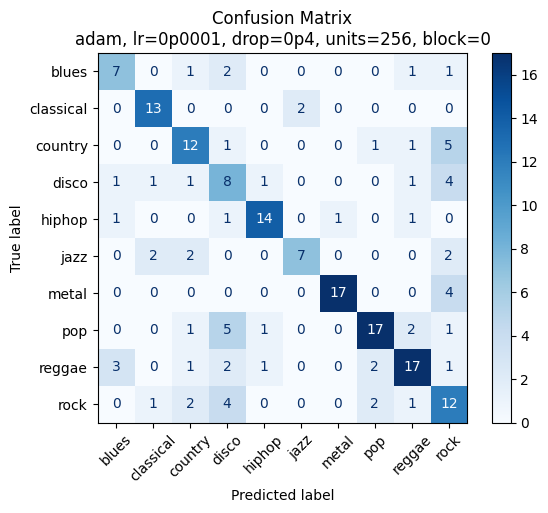

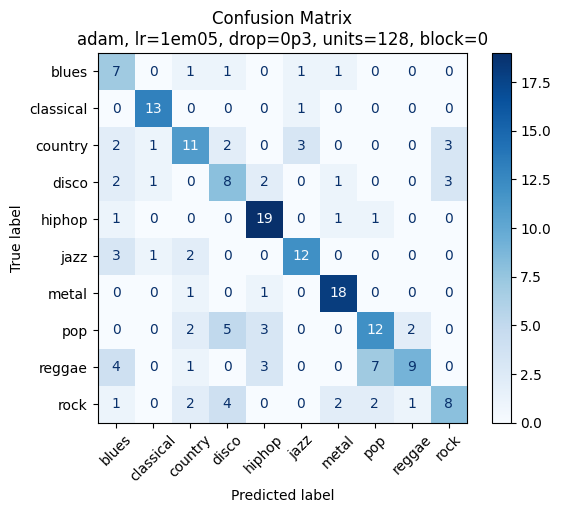

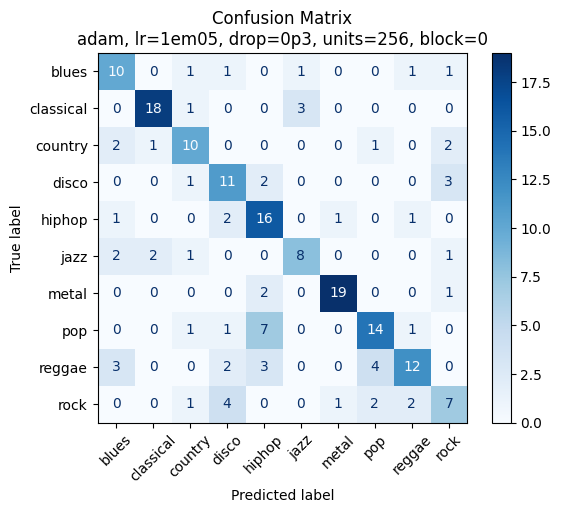

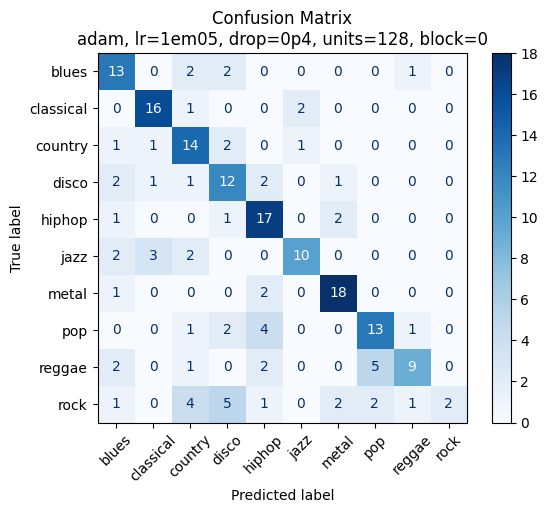

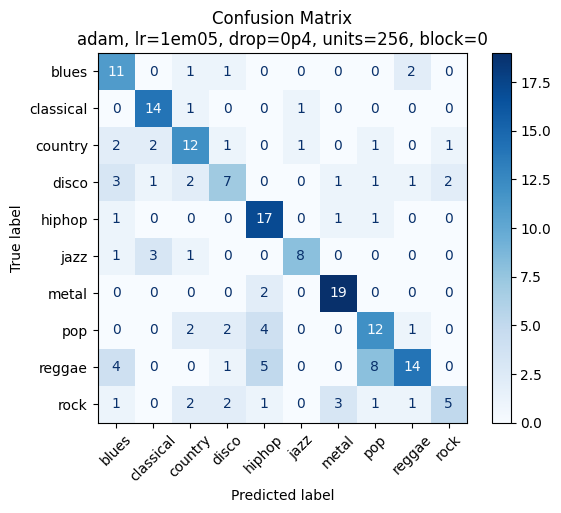

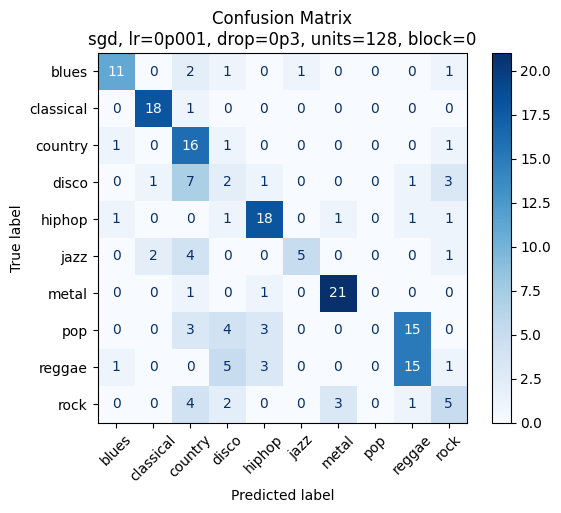

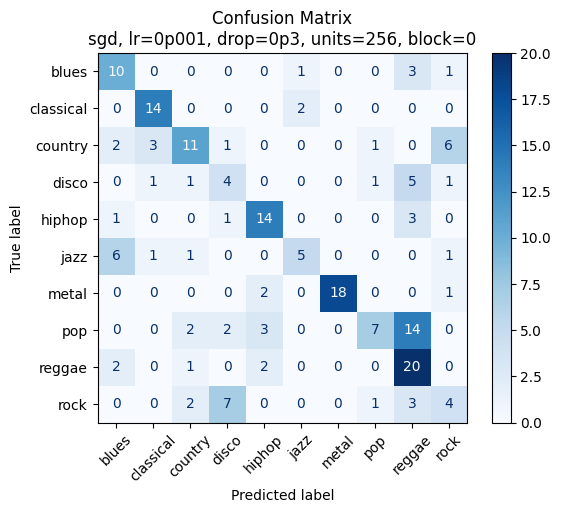

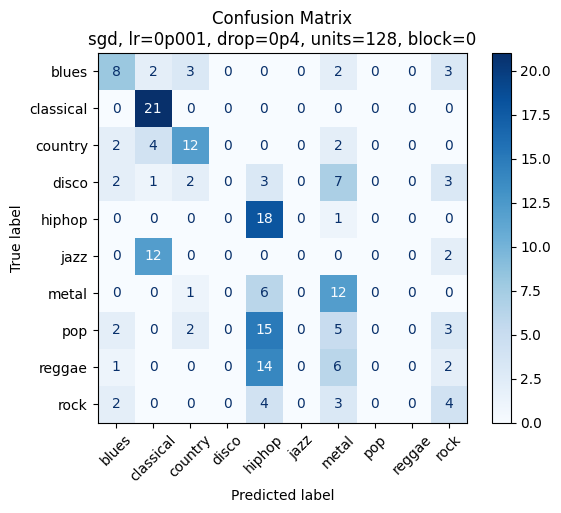

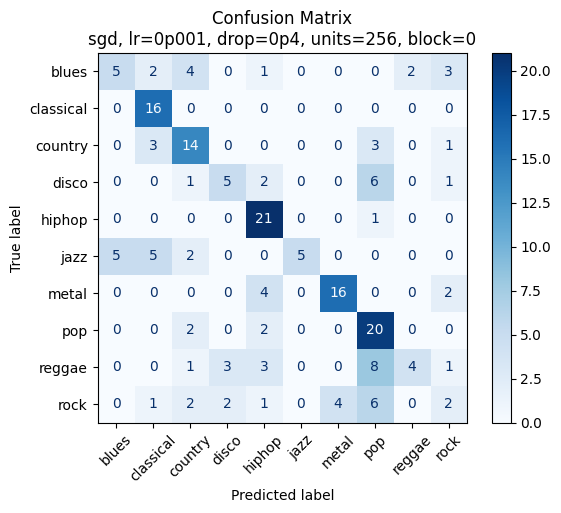

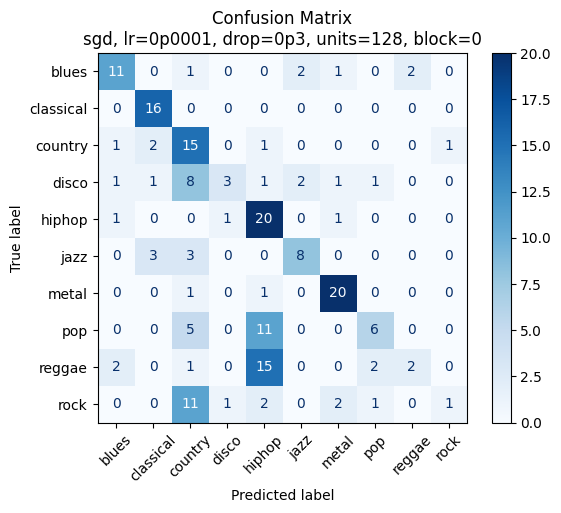

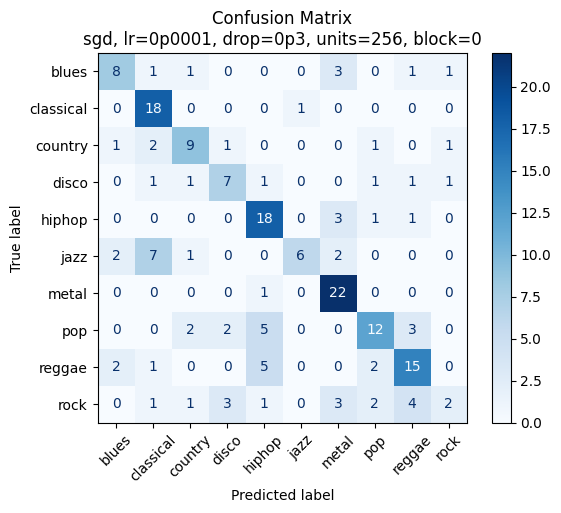

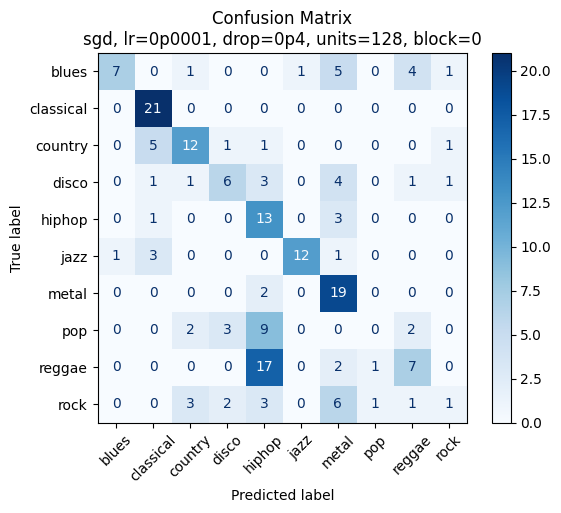

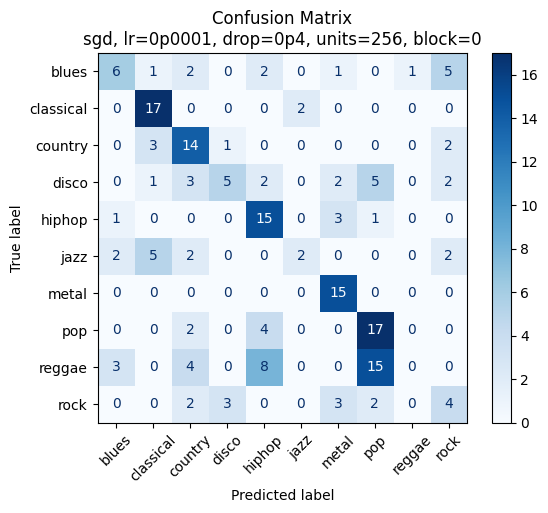

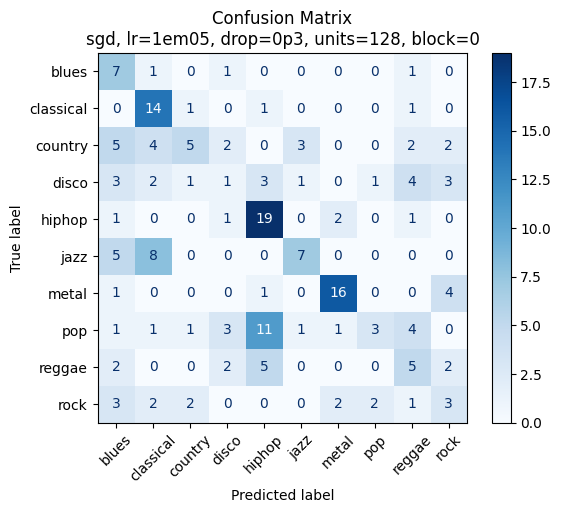

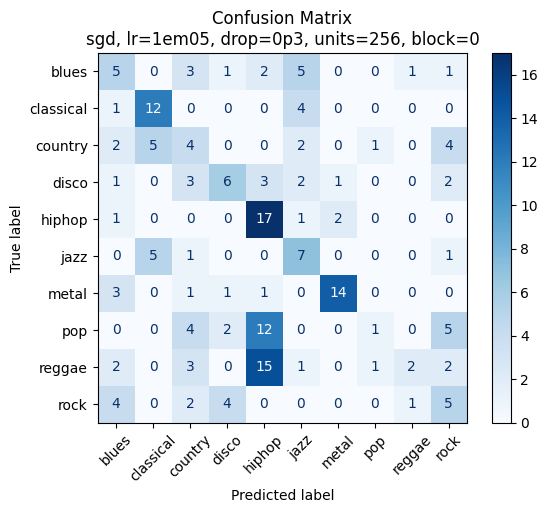

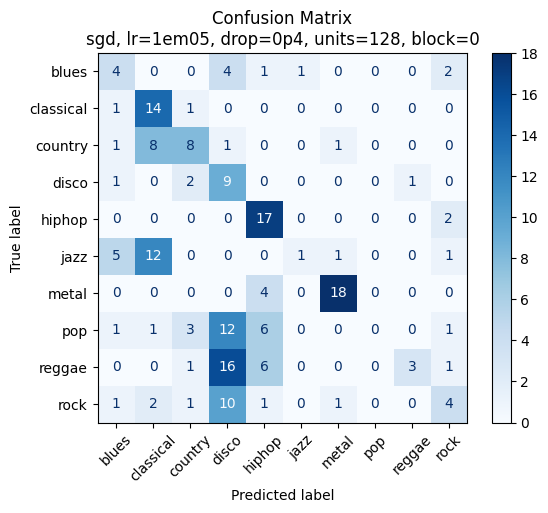

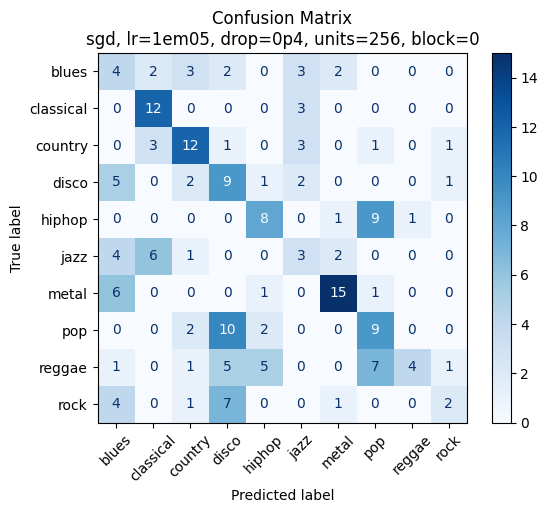

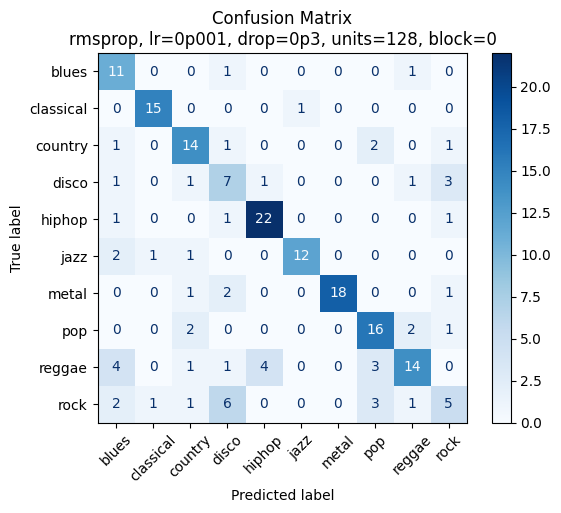

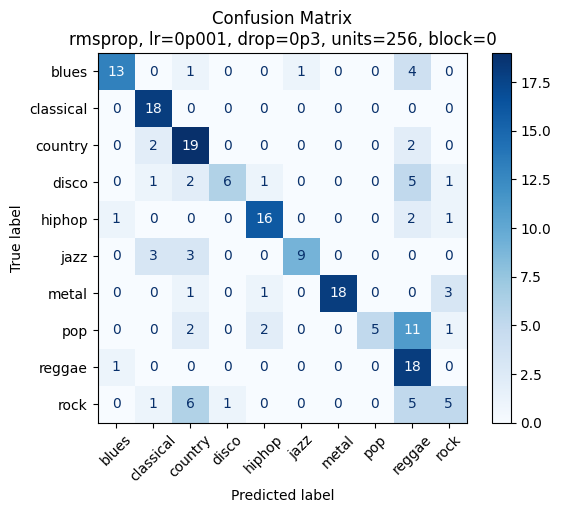

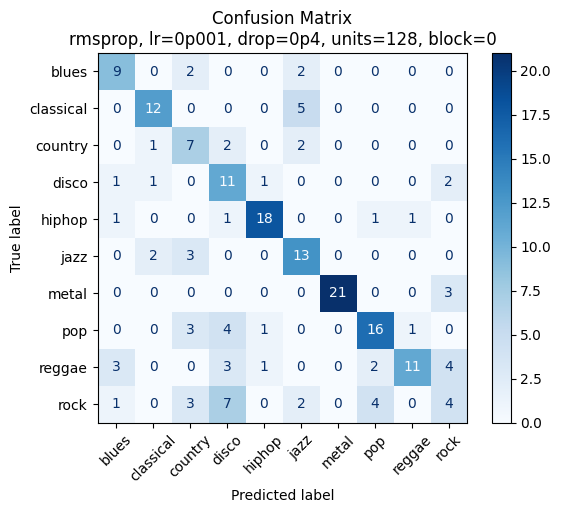

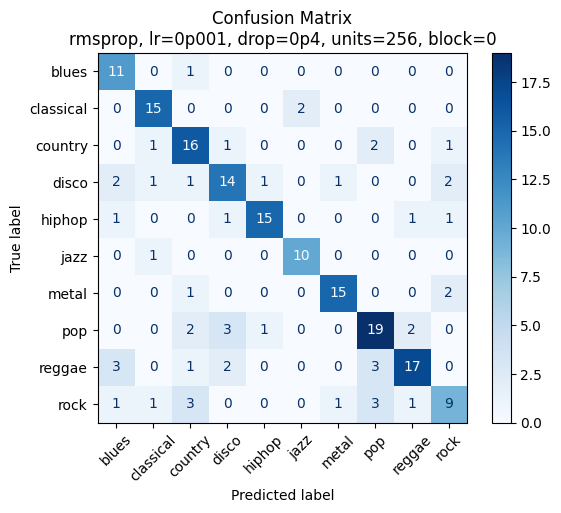

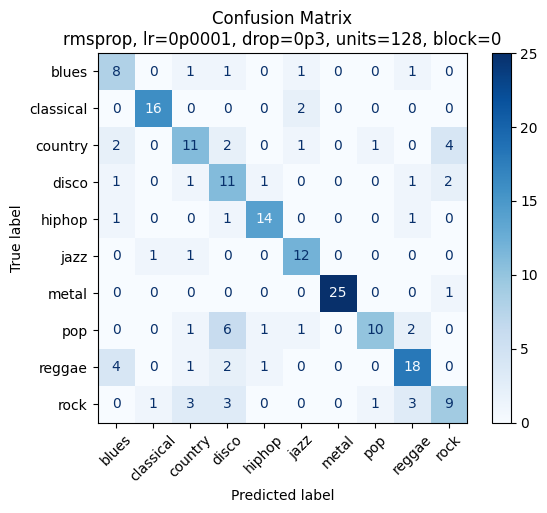

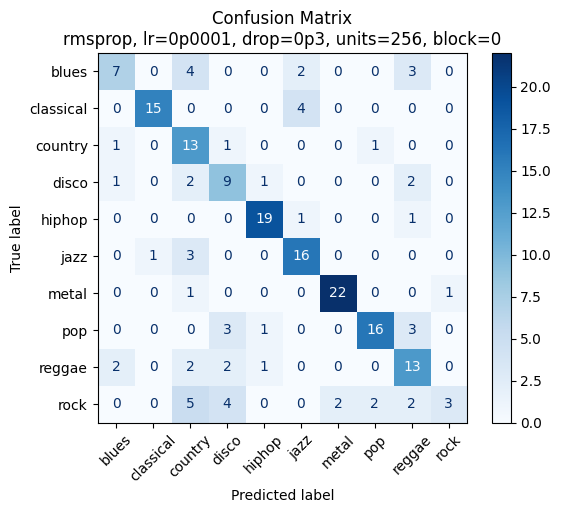

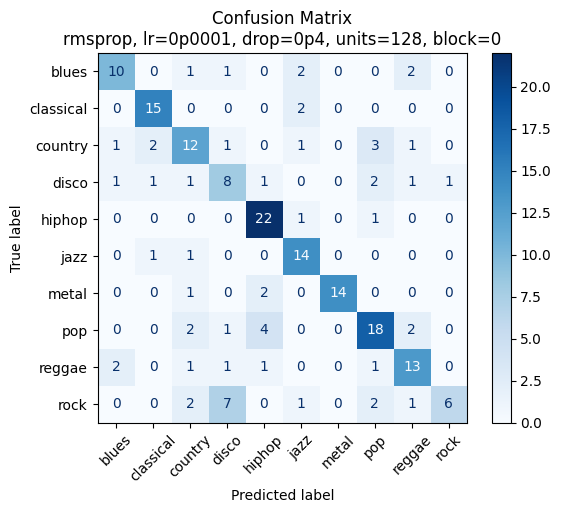

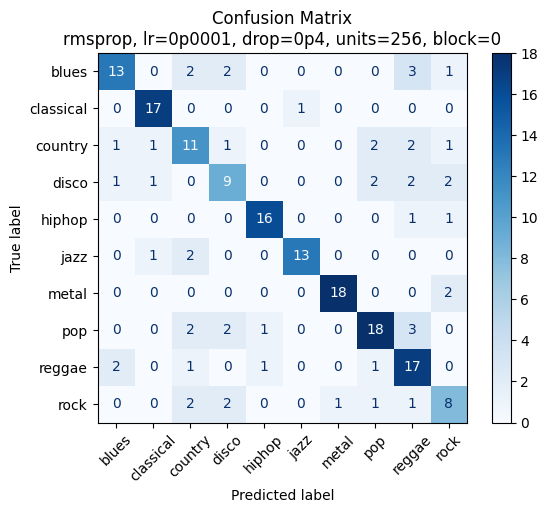

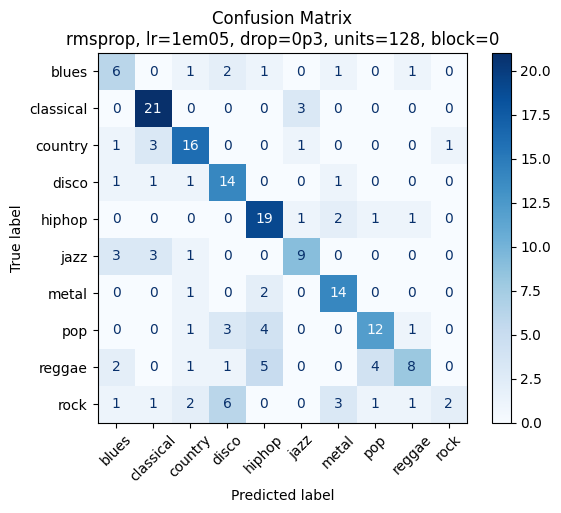

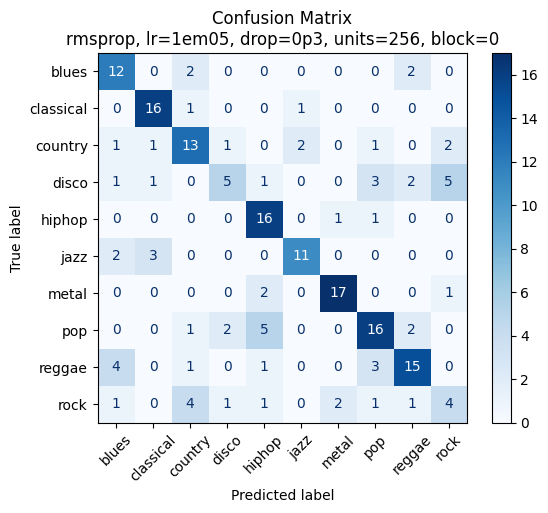

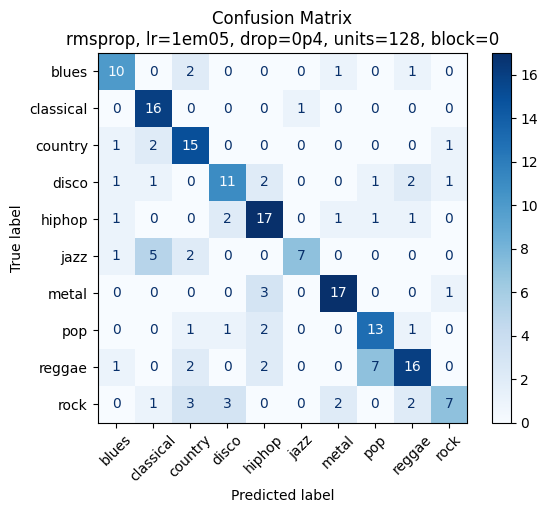

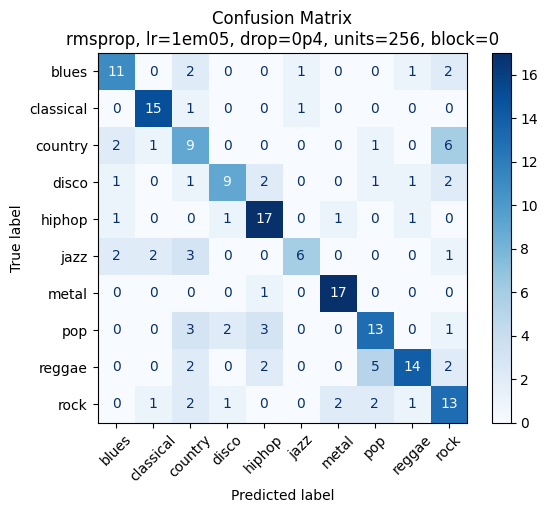

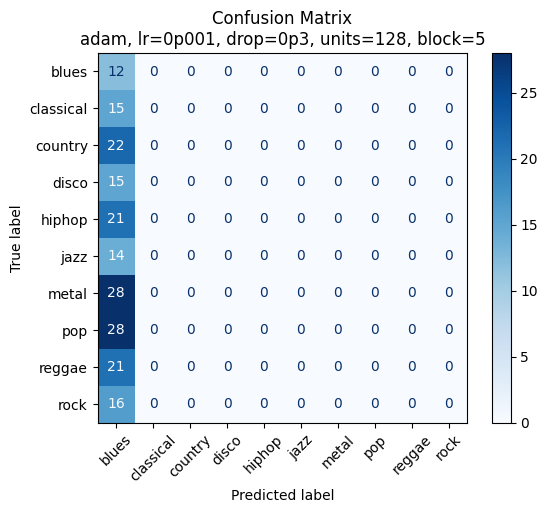

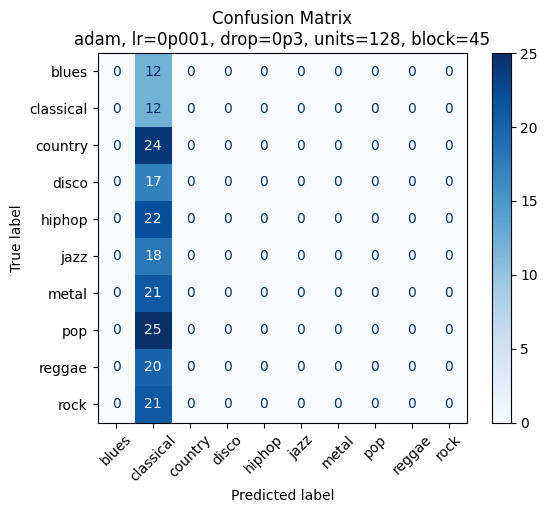

In [45]:
for opt in optimizers:
    for lr in learning_rates:
        for drop in dropout_rates:
            for units in hidden_units:
                run_id = f"{opt}_lr{safe_float_str(lr)}_drop{safe_float_str(drop)}_units{units}_block0"
                history_dir= f"predictions/pred_{run_id}.csv"
                history = pd.read_csv(history_dir)
                plot_confusion_matrix(history,run_id)
                ACC_and_PREC(history,run_id)

for block in blocks_of_layers_to_unlock:
    run_id = f"adam_lr{safe_float_str(1e-3)}_drop{safe_float_str(0.3)}_units128_block{block}"
    history_dir= f"predictions/pred_{run_id}.csv"
    history = pd.read_csv(history_dir)
    plot_confusion_matrix(history,run_id)

# Grad-CAM

In [5]:
def get_img_array(img_path, size=(224, 224)):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = tf.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    _ = model(img_array)

    # Model decompose
    vgg_model = model.get_layer("vgg16")
    classifier_layers = model.layers[2:]
    x = vgg_model.output
    for layer in classifier_layers:
        x = layer(x)
    classifier_model = Model(inputs=vgg_model.output, outputs=x)
    last_conv_layer = vgg_model.get_layer(last_conv_layer_name)

    # Model construction
    grad_model = Model(
        inputs=vgg_model.input,
        outputs=[last_conv_layer.output, classifier_model(vgg_model.output)]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        tape.watch(last_conv_layer_output)
        if pred_index is None:
             pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index

def display_gradcam(img_path, heatmap, genre, number, run_id, alpha=0.4):
    cam_path=f"gradcam2/{run_id}/{genre}/{genre}.{number}.jpg"
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img) * 0.2

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [6]:
numbers = []
for i in range(50):
    if i <10:
        numbers.append(f"0000{i}")
    else:
        numbers.append(f"000{i}")

def gen_csv(csv_path, genre, pred_index):
    file_exists = os.path.exists(csv_path)
    with open(csv_path, mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(["true_genre", "file_name", "predicted_genre"])
        img_filename = f"{genre}.{number}.png"
        predicted_genre = genres[pred_index]
        print(genre, predicted_genre)
        writer.writerow([genre, img_filename, predicted_genre])

In [9]:
os.makedirs("gradcam3", exist_ok=True)
base_dir = Path("..").resolve()
param_sets = [
    ("rmsprop", 0.001, 0.4, 256),
    ("rmsprop", 0.0001, 0.4, 256),
    ("adam", 0.0001, 0.3, 256),
    ("adam", 0.001, 0.4, 256),
    ("rmsprop", 0.0001, 0.3, 128)
]

genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
last_conv_layer_name = "block5_conv3"

output_dir = base_dir / "VGGNet16" / "predictions_csv"
output_dir.mkdir(parents=True, exist_ok=True)

for opt, lr, drop, units in param_sets:
    run_id = f"{opt}_lr{safe_float_str(lr)}_drop{safe_float_str(drop)}_units{units}_block0"
    model_path = base_dir / "VGGNet16" / "models" / f"model_{run_id}.keras"

    if not model_path.exists():
        print(f"Model nie istnieje: {model_path}")
        continue

    model = load_model(model_path)

    for genre in genres:
        gradcam_path = base_dir / "VGGNet16" / "gradcam3" / run_id /f"{genre}"
        if gradcam_path.exists():
            print(f"Pomijam istniejący: {gradcam_path}")
            continue
        os.makedirs(gradcam_path, exist_ok=True)

        for number in numbers:
            img_path = base_dir / "project_data" / "spectrograms" / genre / f"{genre}.{number}.png"
            if not img_path.exists():
                continue

            img_array = get_img_array(img_path)
            heatmap, pred_index = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

            csv_path = output_dir / f"predictions_{run_id}.csv"
            gen_csv(csv_path=csv_path, genre=genre, pred_index=pred_index)

            #display_gradcam(img_path, heatmap, genre, number, run_id)

blues reggae
blues reggae
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues reggae
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues blues
blues hiphop
blues hiphop
blues blues
blues reggae
blues blues
blues reggae
blues hiphop
blues blues
blues reggae
blues blues
blues blues
blues reggae
blues jazz
blues reggae
blues jazz
blues jazz
blues blues
blues jazz
blues blues
blues reggae
classical rock
classical classical
classical blues
classical classical
classical metal
classical jazz
classical classical
classical jazz
classical blues
classical blues
classical jazz
classical classical
classical jazz
classical jazz
classical blues
classical jazz
classical blues
classical jazz
classical jazz
classical blues
classical jazz
classical jazz
classical classical
classical jazz
